In [1]:
import os
from dataPreprocessing import *
import pandas as pd
from torch.utils.data.dataset import random_split
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
RANDOM_SEED = 42
BATCH_SIZE = 32

torch.manual_seed(RANDOM_SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else('mps' if torch.backends.mps.is_available() else 'cpu'))
print(device)

cpu


In [4]:
def plot_loss(train_loss_over_time, val_loss_over_time, model_name):
    epochs = range(1, len(train_loss_over_time) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss_over_time, color='red', label='Train Loss')
    plt.plot(epochs, val_loss_over_time, color='blue', label='Val Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
#folder path were dataset is located
path = 'dataset/'
#initialize empty lists to hold data
train_pos, train_neg, test_pos, test_neg = [], [], [], []
#create a dictionary where the key is the relative path to data and value is empty list
sets_dict = {'train/pos/': train_pos, 'train/neg/': train_neg, 'test/pos/': test_pos, 'test/neg/': test_neg}
#loop through dictionary to read from files and populate empty lists
for dataset in sets_dict:
        file_list = [file for file in os.listdir(os.path.join(path, dataset)) if file.endswith('.txt')]
        file_list = sorted(file_list)
        load_data(os.path.join(path, dataset), file_list, sets_dict[dataset])
#Covert lists to pandas dataframes and combine to form train and test datasets
train_data = pd.concat([pd.DataFrame({'review': train_pos, 'label':1}), pd.DataFrame({'review': train_neg, 'label':0})], axis = 0, ignore_index=True)
test_data = pd.concat([pd.DataFrame({'review': test_pos, 'label':1}), pd.DataFrame({'review': test_neg, 'label':0})], axis = 0, ignore_index=True)

In [6]:
train_data["tokenized"] = train_data["review"].apply(lambda x: tokenize(clean_text(x.lower())))
test_data["tokenized"] = test_data["review"].apply(lambda x: tokenize(clean_text(x.lower())))

In [7]:
train_vocab, reversed_train_vocab = generate_vocab_map(train_data)

In [8]:
generator1 = torch.Generator().manual_seed(RANDOM_SEED)

train_dataset = ReviewDataset(train_vocab, train_data)
train_dataset, val_dataset = random_split(train_dataset,[0.9,0.1], generator=generator1)
test_dataset  = ReviewDataset(train_vocab, test_data)

train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)
test_sampler  = RandomSampler(test_dataset)

In [9]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler, collate_fn=collate_fn)

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Embedding layer for input text
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Transformer Encoder Layer with one layer
        encoder_layers = TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(embedding_dim, 1)
        
        # Activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, src, src_mask=None):
        # src shape: (batch_size, seq_len)
        embedded = self.embedding(src)  # (batch_size, seq_len, embedding_dim)
        embedded = embedded.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embedding_dim)
        
        # Transformer Encoder
        encoded_output = self.transformer_encoder(embedded, src_mask)  # (seq_len, batch_size, embedding_dim)
        encoded_output = encoded_output.mean(dim=0)  # Average pooling over the sequence length dimension
        
        # Fully connected layer
        output = self.fc(encoded_output)  # (batch_size, 1)
        output = self.sigmoid(output).squeeze()  # Squeeze to remove extra dimensions
        
        return output

In [11]:
# Initialize the model
vocab_size = len(train_vocab)
embedding_dim = 16  # Dimension of the embedding
num_heads = 4  # Number of heads for the multi-head attention
hidden_dim = 32  # Dimension of the feedforward network
num_layers = 1  # Number of Transformer encoder layers

model = TransformerModel(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers).to(device)

/Users/miguel/miniconda3/envs/nlp_proj/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
# Loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

/Users/miguel/miniconda3/envs/nlp_proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/5: 100%|██████████| 704/704 [05:51<00:00,  2.00it/s]


Epoch 1 - Training Loss: 0.5974
Epoch 1 - Validation Loss: 0.4504


Epoch 2/5: 100%|██████████| 704/704 [04:28<00:00,  2.62it/s]


Epoch 2 - Training Loss: 0.3730
Epoch 2 - Validation Loss: 0.3661


Epoch 3/5: 100%|██████████| 704/704 [04:16<00:00,  2.75it/s]


Epoch 3 - Training Loss: 0.2929
Epoch 3 - Validation Loss: 0.3523


Epoch 4/5: 100%|██████████| 704/704 [04:20<00:00,  2.70it/s]


Epoch 4 - Training Loss: 0.2457
Epoch 4 - Validation Loss: 0.3257


Epoch 5/5: 100%|██████████| 704/704 [04:22<00:00,  2.68it/s]


Epoch 5 - Training Loss: 0.2070
Epoch 5 - Validation Loss: 0.3349


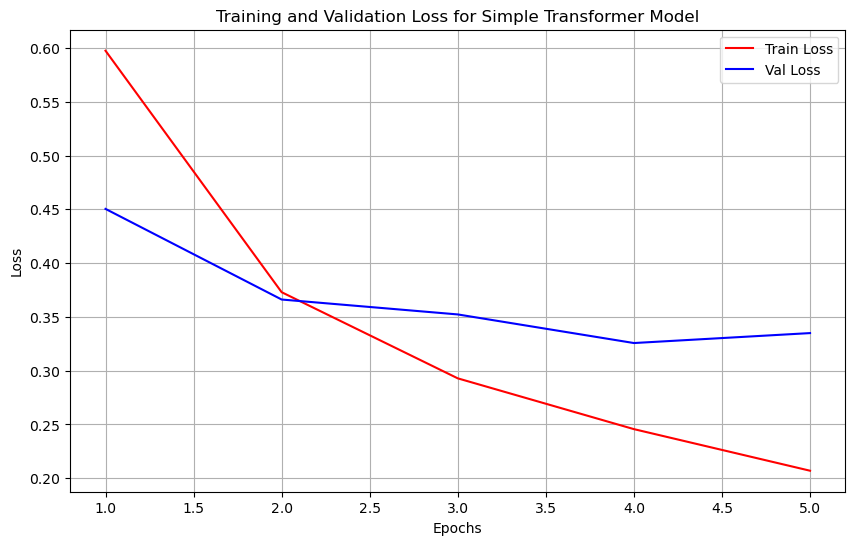

In [13]:
num_epochs = 5
train_loss_over_time = []
val_loss_over_time = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_iterator, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        reviews, labels = batch[0].to(device), batch[1].float().to(device)
        
        optimizer.zero_grad()
        predictions = model(reviews)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_iterator)
    train_loss_over_time.append(avg_train_loss)
    print(f'Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}')
    
    # Validation loop (if applicable)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_iterator:
            reviews, labels = batch[0].to(device), batch[1].float().to(device)
            predictions = model(reviews)
            loss = criterion(predictions, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_iterator)
    val_loss_over_time.append(avg_val_loss)
    print(f'Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}')

# %%
# Plot loss curves
plot_loss(train_loss_over_time, val_loss_over_time, model_name='Simple Transformer Model')

In [14]:
from sklearn.metrics import accuracy_score

# Set the model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_iterator:
        reviews, labels = batch[0].to(device), batch[1].float().to(device)
        
        # Get predictions
        predictions = model(reviews)
        
        # Convert predictions to binary labels (assuming a threshold of 0.5 for binary classification)
        predicted_labels = (predictions >= 0.5).float()
        
        # Collect predictions and true labels
        all_preds.extend(predicted_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print the accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on the test data: {accuracy:.4f}')


Accuracy on the test data: 0.8608


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define the Sparse Autoencoder with Mono-Semantic Constraints
class MonoSemanticAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_lambda=1e-3, orthogonal_lambda=1e-3):
        super(MonoSemanticAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sparsity_lambda = sparsity_lambda
        self.orthogonal_lambda = orthogonal_lambda

    def forward(self, x):
        # Encoder
        encoded = F.relu(self.encoder(x))
        # Decoder
        decoded = self.decoder(encoded)
        return decoded, encoded

    def sparsity_loss(self, encoded):
        # Enforce sparsity by penalizing mean activation
        sparsity_target = torch.mean(encoded, dim=0)
        return self.sparsity_lambda * torch.sum(torch.abs(sparsity_target))
    
    def orthogonality_loss(self):
        # Enforce orthogonality in encoder weights
        W = self.encoder.weight.t()  # Transpose to make columns features
        M = torch.matmul(W, W.t())  # Gram matrix
        I = torch.eye(M.size(0)).to(W.device)  # Identity matrix
        return self.orthogonal_lambda * torch.norm(M - I)

    def loss(self, decoded, input, encoded):
        recon_loss = F.mse_loss(decoded, input)
        sparsity_loss = self.sparsity_loss(encoded)
        orthogonal_loss = self.orthogonality_loss()
        return recon_loss + sparsity_loss + orthogonal_loss


In [37]:
model.eval()
token_activations = []

with torch.no_grad():
    for batch in test_iterator:
        reviews, _ = batch[0].to(device), batch[1].to(device)
        embedded = model.embedding(reviews).permute(1, 0, 2)  # (seq_len, batch_size, embedding_dim)
        encoded_output = model.transformer_encoder(embedded)  # (seq_len, batch_size, embedding_dim)
        
        # Collect token-level activations (reshape to handle all tokens)
        batch_activations = encoded_output.permute(1, 0, 2).reshape(-1, encoded_output.size(-1))
        token_activations.extend(batch_activations.cpu().numpy())

# Convert token activations to tensor
token_activations = torch.tensor(token_activations, dtype=torch.float32)



In [95]:
# Training the Sparse Autoencoder with Mono-Semantic Constraints
sparsity_lambda = 1e-4
orthogonal_lambda = 1e-3
batch_size = 32
num_epochs = 3
learning_rate = 0.001

# Training the Sparse Autoencoder on Token-Level Activations
input_dim = token_activations.shape[1]
hidden_dim = 32  # Increased dimension to account for more features per token
autoencoder = MonoSemanticAutoencoder(input_dim, hidden_dim, sparsity_lambda, orthogonal_lambda).to(device)

optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
autoencoder.train()

for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(token_activations), batch_size):
        batch = token_activations[i:i + batch_size].to(device)
        optimizer.zero_grad()
        decoded, encoded = autoencoder(batch)
        loss = autoencoder.loss(decoded, batch, encoded)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (len(token_activations) / batch_size)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')



Epoch 1/3, Loss: 0.0037
Epoch 2/3, Loss: 0.0012
Epoch 3/3, Loss: 0.0012


In [96]:
# Visualize the Encoded Features
autoencoder.eval()
with torch.no_grad():
    _, encoded_activations = autoencoder(token_activations.to(device))

encoded_activations = encoded_activations.cpu().numpy()

In [97]:
encoded_activations[0]

array([0.0000000e+00, 8.2789280e-02, 6.3282408e-02, 6.4154434e-01,
       0.0000000e+00, 0.0000000e+00, 1.8690243e-02, 0.0000000e+00,
       2.7116126e-01, 0.0000000e+00, 8.3181798e-01, 0.0000000e+00,
       9.6250020e-02, 7.9169869e-05, 4.0566897e-01, 1.7509943e-01,
       1.0268129e-03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       8.9590031e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.2521810e-01, 0.0000000e+00, 0.0000000e+00, 6.6032588e-01,
       7.4238665e-02, 1.7904924e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [98]:
encoded_activations = encoded_activations.reshape(25000,400,32)

In [99]:
encoded_activations.shape

(25000, 400, 32)

In [100]:
def pad_or_trim(tokens, length=400, pad_token=""):
    """Pads or trims a list of tokens to a specified length."""
    if len(tokens) > length:
        # Trim the list to the desired length
        return tokens[:length]
    else:
        # Pad the list with the pad_token
        return tokens + [pad_token] * (length - len(tokens))

# Apply the function to create the tokenized column
test_data["tokenized"] = test_data["review"].apply(
    lambda x: pad_or_trim(tokenize(clean_text(x.lower())))
)

# Verify the length of each tokenized review
print(test_data["tokenized"].apply(len).value_counts())

tokenized
400    25000
Name: count, dtype: int64


In [ ]:
def print_max_activation_per_feature(encoded_activations):
    """
    Prints the maximum activation across all reviews and all tokens for each feature.
    
    Parameters:
    encoded_activations (numpy.ndarray): A 3D array of shape (num_reviews, num_tokens, num_features)
                                         containing the activations.
    """
    # Calculate the maximum activation for each feature across all reviews and tokens
    max_activations = encoded_activations.max(axis=(0, 1))
    
    # Print the maximum activation for each feature
    print("Maximum activation for each feature:")
    for feature_index, max_activation in enumerate(max_activations):
        print(f"Feature {feature_index}: Maximum Activation = {max_activation}")

# Example usage
print_max_activation_per_feature(encoded_activations)


NameError: name 'encoded_activations' is not defined

In [102]:
def print_top_tokens(encoded_activations, tokens, feature_number, top_n=10):
    """
    Prints the tokens with the top activations for a specified feature number.
    
    Parameters:
    encoded_activations (numpy.ndarray): A 3D array of shape (num_reviews, num_tokens, num_features) 
                                         containing the activations.
    tokens (list of list of str): A list where each element is a list of tokens corresponding to each review.
    feature_number (int): The feature index for which we want to find the top activating tokens.
    top_n (int): The number of tokens to print with the highest activations for the given feature.
    """
    # Check if the feature_number is within valid range
    if feature_number < 0 or feature_number >= encoded_activations.shape[2]:
        print("Invalid feature number. Please provide a valid feature number.")
        return
    
    # Flatten the activations and token associations for all reviews
    all_tokens = []
    all_activations = []

    for i in range(len(tokens)):
        all_tokens.extend(tokens[i])  # Collect tokens from each review
        all_activations.extend(encoded_activations[i, :, feature_number])  # Collect activations for the specified feature

    # Create a list of tuples (activation, token) and sort by activation in descending order
    token_activation_pairs = list(zip(all_activations, all_tokens))
    sorted_pairs = sorted(token_activation_pairs, key=lambda x: x[0], reverse=True)

    # Print the top_n tokens with the highest activations for the specified feature
    print(f"Top {top_n} tokens for feature {feature_number} with highest activations:")
    for i in range(min(top_n, len(sorted_pairs))):
        activation, token = sorted_pairs[i]
        print(f"Token: '{token}', Activation: {activation}")

# Example usage
print_top_tokens(encoded_activations, test_data["tokenized"].tolist(), feature_number=3, top_n=10)


Top 10 tokens for feature 3 with highest activations:
Token: '', Activation: 2.6291635036468506
Token: 'out', Activation: 2.6272895336151123
Token: 'in', Activation: 2.6190810203552246
Token: 'the', Activation: 2.617668390274048
Token: '"', Activation: 2.6121881008148193
Token: 'academy', Activation: 2.6121881008148193
Token: '', Activation: 2.607008218765259
Token: '', Activation: 2.6051218509674072
Token: '.', Activation: 2.6019961833953857
Token: 'television', Activation: 2.6019961833953857
